## Q2) Can lexical diversity and realted features reliably predict whether a text was written pre- or post- ChatGPT (binary classification)

### Methodology (Machine Learning & Deep Learning)

To address this question, we frame the task as a binary text classification problem, where the objective is to predict whether a news sentence was written before or after the public release of ChatGPT.

We evaluate the predictive power of lexical information using two complementary modeling approaches.

First, we establish machine learning baselines using TF-IDF representations of the texts. The dataset is split into stratified training and test sets to preserve class balance. Texts are vectorized using unigram and bigram TF-IDF features, and several supervised classifiers are trained, including Logistic Regression, Linear SVM, Naive Bayes, and Random Forests.
These models serve as interpretable baselines to assess whether surface lexical patterns alone are sufficient to distinguish pre- and post-ChatGPT texts. Performance is evaluated using F1-score, and confusion matrices are inspected to analyse systematic errors.

In addition, we perform a qualitative error analysis, comparing correctly and incorrectly classified texts with respect to length, lexical diversity and stopword density. This allows us to determine whether misclassifications are associated with specific lexical characteristics or whether errors occur uniformly across the data.

Second, we train a deep learning classifier based on a pre-trained multilingual transformer (DistilBERT), which is fine-tuned end-to-end on the same binary classification task. Unlike the TF-IDF models, this approach learns contextualized representations that capture syntactic and semantic patterns beyond surface lexical statistics. The model is trained using cross-entropy loss, evaluated with F1-score, and tested on held-out data as well as on manually selected example texts.

In [ ]:
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import time
from tqdm.auto import tqdm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

We evaluate this question using several supervised machine learning models trained on TF-IDF representations of the texts, including Logistic Regression, Linear SVM, Naive Bayes, and Random Forests.

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42, #reporducibility
    stratify=y
)

len(X_train), len(X_test)


(320000, 80000)

In [ ]:
# create the vectorizer
tfidf = TfidfVectorizer(
    max_features=100000,
    ngram_range=(1,2),  # unigrams + bigrams
    min_df=5, # ignore extremely rare tokens
)

# fit on training data ONLY
X_train_tfidf = tfidf.fit_transform(X_train)

# transform test data
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((320000, 100000), (80000, 100000))

In [ ]:
# create model
lr = ProgressLogisticRegression(
    max_iter=200,
    n_jobs=-1,# use all CPU cores
    solver="lbfgs",
    C=1.0,
)

# train
lr.fit(X_train_tfidf, y_train)

# evaluate
y_pred = lr.predict(X_test_tfidf)

print("\nClassification Report =")
print(classification_report(y_test, y_pred, digits=4))

print("\n Confusion Matrix =")
print(confusion_matrix(y_test, y_pred))


Training Logistic Regression...
Training completed in 4.82 seconds.

Classification Report =
              precision    recall  f1-score   support

           0     0.6065    0.6082    0.6074     40000
           1     0.6071    0.6054    0.6062     40000

    accuracy                         0.6068     80000
   macro avg     0.6068    0.6068    0.6068     80000
weighted avg     0.6068    0.6068    0.6068     80000


 Confusion Matrix =
[[24330 15670]
 [15785 24215]]


In [ ]:
t0 = time.time()
svm = LinearSVC(C=1.0)

svm.fit(X_train_tfidf, y_train)
print(f"Training completed in {time.time() - t0:.2f} seconds.")

# evaluate
y_pred_svm = svm.predict(X_test_tfidf)

print("\nClassification Report Linear SVM")
print(classification_report(y_test, y_pred_svm, digits=4))

print("\nconfussion matris SVM")
print(confusion_matrix(y_test, y_pred_svm))


Training completed in 16.01 seconds.

Classification Report Linear SVM
              precision    recall  f1-score   support

           0     0.5915    0.5964    0.5940     40000
           1     0.5930    0.5881    0.5906     40000

    accuracy                         0.5923     80000
   macro avg     0.5923    0.5923    0.5923     80000
weighted avg     0.5923    0.5923    0.5923     80000


confussion matris SVM
[[23857 16143]
 [16475 23525]]


In [ ]:
t0 = time.time()
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

print(f"Training completed in {time.time() - t0:.2f} seconds.")

# evaluate
y_pred_nb = nb.predict(X_test_tfidf)

print("\nClassification Report (Naive Bayes)=")
print(classification_report(y_test, y_pred_nb, digits=4))

print("\nConfusion Matrix (Naive Bayes) =")
print(confusion_matrix(y_test, y_pred_nb))


Training completed in 0.24 seconds.

Classification Report (Naive Bayes)=
              precision    recall  f1-score   support

           0     0.6068    0.6057    0.6063     40000
           1     0.6064    0.6075    0.6070     40000

    accuracy                         0.6066     80000
   macro avg     0.6066    0.6066    0.6066     80000
weighted avg     0.6066    0.6066    0.6066     80000


Confusion Matrix (Naive Bayes) =
[[24229 15771]
 [15699 24301]]


In [ ]:
#evaluation
y_pred_rf = rf.predict(X_test_svd)

print("\nClassification Report (Random Forest) =")
print(classification_report(y_test, y_pred_rf, digits=4))

print("\nConfusion Matrix (Random Forest) =")
print(confusion_matrix(y_test, y_pred_rf))


Classification Report (Random Forest) =
              precision    recall  f1-score   support

           0     0.5518    0.4814    0.5142     40000
           1     0.5401    0.6089    0.5724     40000

    accuracy                         0.5452     80000
   macro avg     0.5459    0.5452    0.5433     80000
weighted avg     0.5459    0.5452    0.5433     80000


Confusion Matrix (Random Forest) =
[[19255 20745]
 [15642 24358]]


Across all classical models, performance remains moderate, with F1-scores slightly above chance level. Differences between classifiers are small, suggesting that the limitation lies in the feature representation rather than the model choice.

To better understand model limitations, we analyze systematic misclassifications. Figures shows the token length distribution for correctly and incorrectly classified texts. The distributions largely overlap, indicating that missclasification is not driven vy lenth

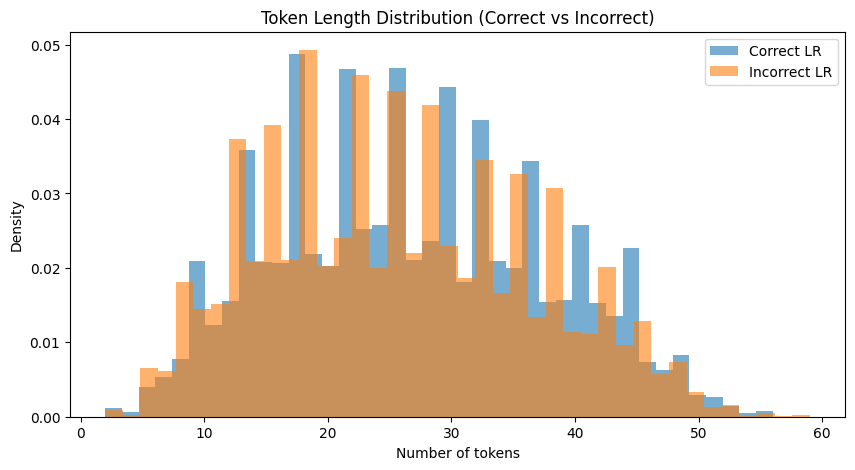

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# compute lengths
len_correct = [compute_metrics(X_test[i])["tokens"] for i in correct_lr[:5000]]
len_incorrect = [compute_metrics(X_test[i])["tokens"] for i in errors_lr[:5000]]

plt.figure(figsize=(10,5))

plt.hist(len_correct, bins=40, alpha=0.6, label="Correct LR", density=True)
plt.hist(len_incorrect, bins=40, alpha=0.6, label="Incorrect LR", density=True)

plt.title("Token Length Distribution (Correct vs Incorrect)")
plt.xlabel("Number of tokens")
plt.ylabel("Density")
plt.legend()
plt.show()


A similar pattern is observed for lexical diversity measures, where correctly and incorrectly classified texts exhibit nearly identical distributions.

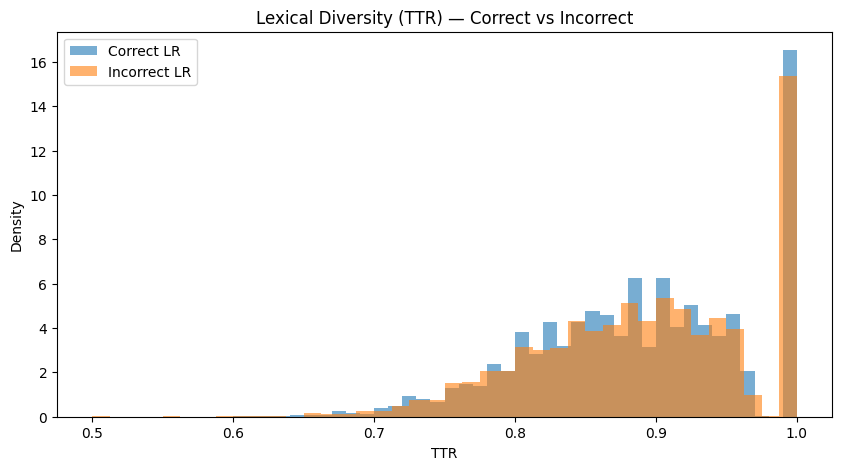

In [ ]:
ttr_correct = [compute_metrics(X_test[i])["ttr"] for i in correct_lr[:5000]]
ttr_incorrect = [compute_metrics(X_test[i])["ttr"] for i in errors_lr[:5000]]

plt.figure(figsize=(10,5))

plt.hist(ttr_correct, bins=40, alpha=0.6, label="Correct LR", density=True)
plt.hist(ttr_incorrect, bins=40, alpha=0.6, label="Incorrect LR", density=True)

plt.title("Lexical Diversity (TTR) — Correct vs Incorrect")
plt.xlabel("TTR")
plt.ylabel("Density")
plt.legend()
plt.show()


 ---
 In addition, we analyze a fine-tuned transformer-based classifier (DistilBERT) to assess whether deeper contextual representations improve separability.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()


C:\Users\adrig\AppData\Local\Temp\ipykernel_10088\486450170.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.688400,0.679345,0.551200,0.503485
1000,0.676700,0.672353,0.553750,0.332411
1500,0.668200,0.661710,0.579300,0.626443
2000,0.652400,0.667087,0.567900,0.395580
2500,0.666900,0.658348,0.576200,0.644344
3000,0.660600,0.655098,0.586350,0.520822
3500,0.651000,0.653766,0.592250,0.619370


TrainOutput(global_step=3500, training_loss=0.6677095467703683, metrics={'train_runtime': 548.3328, 'train_samples_per_second': 291.794, 'train_steps_per_second': 18.237, 'total_flos': 928497114029568.0, 'train_loss': 0.6677095467703683, 'epoch': 0.7})

In [ ]:
trainer.evaluate()


{'eval_loss': 0.6583478450775146,
 'eval_accuracy': 0.5762,
 'eval_f1': 0.6443437395099026,
 'eval_runtime': 13.6037,
 'eval_samples_per_second': 1470.184,
 'eval_steps_per_second': 45.943,
 'epoch': 0.7}

The transformer-based model achieves slightly higher F1-scores, but still produces low-confidence predictions for individual texts, as confirmed by a qualitative stress test on manually written and ChatGPT-generated news articles.

In [ ]:
import os

candidates_human = ["news/new_human_es.txt"]
candidates_gpt   = ["news/new_chatgpt_es.txt"]

def read_first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            with open(p, "r", encoding="utf-8") as f:
                return p, f.read()
    raise FileNotFoundError(f"none of these files exist: {paths}")

human_path, human_text = read_first_existing(candidates_human)
gpt_path, gpt_text     = read_first_existing(candidates_gpt)

print("human file:", human_path, "| chars:", len(human_text))
print("gpt file:", gpt_path, "| chars:", len(gpt_text))

pred_human = predict_text(human_text)
pred_gpt   = predict_text(gpt_text)

print("\nHUMAN:", pred_human)
print("GPT  :", pred_gpt)


human file: news/new_human_es.txt | chars: 757
gpt file: news/new_chatgpt_es.txt | chars: 743

HUMAN: {'pred_label': 0, 'prob_pre': 0.5370333790779114, 'prob_post': 0.4629666209220886}
GPT  : {'pred_label': 1, 'prob_pre': 0.48860102891921997, 'prob_post': 0.51139897108078}
